In [1]:
from dask.distributed import Client, LocalCluster

# Example: 4 workers, 1 thread each
cluster = LocalCluster(n_workers=4, threads_per_worker=1)
client = Client(cluster)

print("Dashboard:", client.dashboard_link)


Dashboard: http://127.0.0.1:8787/status


In [2]:
# check if everything went smoothly
print(client)


<Client: 'tcp://127.0.0.1:44001' processes=4 threads=4, memory=5.79 GiB>


In [3]:
import dask.array as da
import dask
import numpy as np
from scipy.linalg import solve_triangular 
from sklearn.datasets import fetch_california_housing

# Download California Housing dataset
data = fetch_california_housing(as_frame=True)

# Convert features into Dask Array (it's a matrix).
n_partition = 3        # number of partition in memory. We have 4 VMS (1 master + 3 workers), so let's start with just 3 partitions
length_partition = data.data.shape[0] // n_partition
X_da = da.from_array(data.data.values, chunks=(length_partition, data.data.shape[1]))

print("Number of Dask partitions:",  X_da.npartitions) 
print("Length of each partition:", length_partition, "rows")
print("Length of the whole dataset:", data.data.shape[0], "rows")


Number of Dask partitions: 3
Length of each partition: 6880 rows
Length of the whole dataset: 20640 rows


In [4]:
print(X_da)


dask.array<array, shape=(20640, 8), dtype=float64, chunksize=(6880, 8), chunktype=numpy.ndarray>


In [11]:
def indirect_serial(A, n_div):

    """
    Indirect TSQR (serial, NumPy).
    Splits A by rows into n_div blocks, computes local R_i via QR,
    reduces to global R by QR on the stacked R_i, then recovers Q = A R^{-1}.
    Returns (Q, R).
    """

    n_samp = A.shape[0]
    
    div_points = int(np.floor(n_samp/n_div))
    A_divided = []
    Ri = []
    
    A_divided = [A[div_points * i : div_points * (i + 1)] for i in range(n_div - 1)]
    A_divided.append(A[(n_div - 1) * div_points:, :])   # In the case n_samp wasn't divisible by n_div

    Ri = [np.linalg.qr(Ai, mode="reduced")[1] for Ai in A_divided]
    
    R_stack = np.concatenate(Ri, axis = 0)

    # Step 3. Stack R_i and compute global R

    _, R = np.linalg.qr(R_stack, mode="reduced")


    """try:
        I = np.eye(n, dtype=A.dtype)
        Rinv = solve_triangular(R, I, lower=False)
    except Exception:
        Rinv = np.linalg.inv(R)  # fallback if SciPy not available
    Q = A @ Rinv"""

    """
    np.linalg.inv(R) is numerically less stable than solving the triangular system.
    R is upper-triangular, so it is possible to try to use scipy.linalg.solve_triangular.
    """
    Q = A @ np.linalg.inv(R)


    return Q, R


def compute_R(block):
    # np.linalg.qr with mode='r' gives just the R matrix
    R = np.linalg.qr(block, mode="r")
    return R


def indirect_parallel(X_da):

    """
    Indirect TSQR with Dask.
    Input:
        X_da : Dask Array (m x n), chunked row-wise
    Output:
        R    : final global triangular factor (n x n, NumPy array on driver)
        Q_da : Dask Array (m x n), representing Q = A R^{-1} (lazy)
    """


    n_cols = X_da.shape[1]

    R_blocks = X_da.map_blocks(compute_R, dtype=X_da.dtype, chunks=(n_cols, n_cols))
    # Now R_blocks is a stack of n x n matrices (one per partition)
    # Its shape is (#chunks * n, n)

    R_blocks.visualize(filename="fig/R_blocks_graph", format="png")
 

   
    #Dask has da.linalg.qr, but it assumes the whole array is large and chunked regularly.
    #To get the final global R, you must combine all the Ri
    #That means at some point, the data has to come together into a single place (can’t keep it sharded).
    # So we bring the data to the driver because it is very small, because it optimizes the uses of np.linalg.qr, we are gathering the small stuff
    R_stack = R_blocks.compute()   # NumPy array, shape (p*n, n)

    # Small QR on driver to combine them into the final R
    R = np.linalg.qr(R_stack, mode="r")


    # Instead of materializing Q, compute a small R^{-1} (n x n).
    I = np.eye(n_cols, dtype=X_da.dtype)
    R_inv = solve_triangular(R, I, lower=False)  # stable

    # Broadcast Rinv to every chunk: Q = A @ R^{-1}
    Q_da = X_da @ R_inv   # still a Dask Array, lazy

    return Q_da, R      #Q_da because it is lazy, it is still a Dask array




In [12]:
%%time

Q, R = indirect_serial(data.data.values, 50)
size = 20640 / 50 * 8 * 8 #rows_per_chunk × n_cols × 8 bytes
print("The size for each chunk is :", size/1e6, "Mb")


The size for each chunk is : 0.0264192 Mb
CPU times: user 25.2 ms, sys: 1.36 ms, total: 26.6 ms
Wall time: 20.4 ms


In [13]:
%%time

Q_da, R = indirect_parallel(X_da)   # X_da is already splitted into three partitions


print("Final R shape:", R.shape)  # (n, n), small
print("Q is lazy:", Q_da)         # Dask Array, not yet computed

print("Chunks:", X_da.chunks)
print("Number of partitions:", X_da.npartitions)
print("Total size [MB]:", X_da.nbytes / 1e6)
print("Chunk size [MB]:", X_da.nbytes / X_da.npartitions / 1e6)    # 10–100 MB

print("Shape:", X_da.shape)
print("Chunks:", X_da.chunks)
print("Partitions:", X_da.npartitions)
print("Total size [MB]:", X_da.nbytes/1e6)
print("Avg chunk [MB]:", (X_da.nbytes/X_da.npartitions)/1e6)


#print("Compact sanity check:", X_da.shape, "(m,n);", R_blocks.shape, "(n *n_partitions, n);", R.shape, "(n,n)" )


Final R shape: (8, 8)
Q is lazy: dask.array<getitem, shape=(20640, 8), dtype=float64, chunksize=(6880, 8), chunktype=numpy.ndarray>
Chunks: ((6880, 6880, 6880), (8,))
Number of partitions: 3
Total size [MB]: 1.32096
Chunk size [MB]: 0.44032
Shape: (20640, 8)
Chunks: ((6880, 6880, 6880), (8,))
Partitions: 3
Total size [MB]: 1.32096
Avg chunk [MB]: 0.44032
CPU times: user 87.9 ms, sys: 48.5 ms, total: 136 ms
Wall time: 218 ms


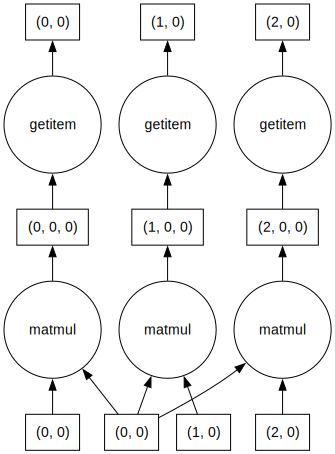

In [15]:

Q_da.visualize("fig/q_mul_graph.svg")
